In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
path_to_fastai_dev_local = '/home/heye0507/fastai_dev'
sys.path.append(path_to_fastai_dev_local)
sys.path.append('/home/jupyter/.local/bin')
print(sys.version)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [3]:
import torch
torch.__version__

'1.2.0'

In [4]:
torch.cuda.is_available()

True

In [5]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *
from fastai2.callback.tracker import *
from efficientnet_pytorch import EfficientNet

from PIL import Image

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
#set_seed(42)
#set_num_threads(1)

In [6]:
path = Path('/home/jupyter/rsns')
path_df = path/'data'
path_trn = path/'data/raw/stage_1_train_images'
path_tst = path/'data/raw/stage_1_test_images'

In [7]:
df_lbls = pd.read_feather(path_df/'labels.fth')
df_tst = pd.read_feather(path_df/'df_tst.fth').set_index('SOPInstanceUID')
df_trn = pd.read_feather(path_df/'df_trn.fth').dropna(subset=['img_pct_window'])
df_trn['fname'] = df_trn['fname'].apply(lambda x: str(path)+'/data/raw/stage_1_train_images/' + str(Path(x).stem) + '.dcm')
df_tst['fname'] = df_tst['fname'].apply(lambda x: str(path)+'/data/raw/stage_1_test_images/' + str(Path(x).stem) + '.dcm')
comb = df_trn.join(df_lbls.set_index('ID'),'SOPInstanceUID')
df_comb = comb.set_index('SOPInstanceUID')
bins = (path_df/'bins.pkl').load()

In [8]:
set_seed(42)
patients = df_comb.PatientID.unique()
pat_mask = np.random.random(len(patients))<0.8
pat_trn = patients[pat_mask]
mask = df_comb.PatientID.isin(pat_trn)
#df_comb['is_valid'] = mask

In [16]:
mask = df_comb.PatientID.isin(pat_trn)

In [22]:
mask

SOPInstanceUID
ID_231d901c1     True
ID_994bc0470    False
ID_127689cce     True
ID_25457734a     True
ID_81c9aa125     True
                ...  
ID_1b415e1cc     True
ID_59ec44ad3     True
ID_c6516b047     True
ID_2c0ac4759    False
ID_19eede6a5    False
Name: PatientID, Length: 674257, dtype: bool

In [33]:
df_comb['is_valid'] = mask

In [24]:
splits[0]

(#538148) [0,2,3,4,5,6,8,9,10,13...]

In [9]:
def split_data(df):
    idx = L.range(df)
    mask = df.PatientID.isin(pat_trn)
    return idx[mask],idx[~mask]

splits = split_data(df_comb)

In [21]:
splits

((#538148) [0,2,3,4,5,6,8,9,10,13...],
 (#136109) [1,7,11,12,33,34,35,43,50,52...])

In [10]:
df_trn_new = df_comb.iloc[splits[0]]
p1 = L.range(df_comb)[df_comb.PatientID==df_trn_new.PatientID[0]]
assert len(p1) == len(set(p1) & set(splits[0]))

In [11]:
def filename(o): return os.path.splitext(os.path.basename(o))[0]

fns = L(list(df_comb.fname)).map(filename)
fn = fns[0]
fn

'ID_231d901c1'

In [12]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    
def dcm_tfm(fn): 
    fn = (path_trn/fn).with_suffix('.dcm')
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    px = x.scaled_px
    return TensorImage(px.to_3chan(dicom_windows.brain,dicom_windows.subdural, bins=bins))

torch.Size([3, 512, 512])

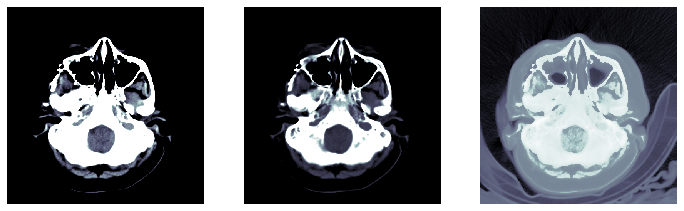

In [12]:
dcm = dcm_tfm(fns[300])
show_images(dcm)
dcm.shape

In [13]:
htypes = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
def fn2label(fn): return df_comb.loc[fn][htypes].values.astype(np.float32)
fn2label(fn)

array([1., 0., 0., 0., 1., 0.], dtype=float32)

In [14]:
bs,nw = 64, 8

In [15]:
def get_data(bs, sz):
    return dsrc.databunch(bs=bs, num_workers=nw, after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

In [16]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [8]:
BaseLoss??

In [16]:
loss_weights = to_device(tensor(2.0, 1, 1, 1, 1, 1))
loss_func = BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, 
    is_2d=False, activation=torch.sigmoid)
opt_func = partial(Adam, wd=0.01, eps=1e-3)
#metrics=[accuracy_multi,accuracy_any]

In [17]:
aug = aug_transforms(flip_vert=True,max_rotate=60.,p_lighting=0.,max_warp=0.)

In [18]:
tfms = [[dcm_tfm], [fn2label,EncodedMultiCategorize(htypes)]]
dsrc = DataSource(fns, tfms, splits=splits)
nrm = Normalize(tensor([0.485, 0.456, 0.406]), tensor([0.229, 0.224, 0.225]))
batch_tfms = [nrm, Cuda(), *aug]

In [19]:
dbch = get_data(64,256)

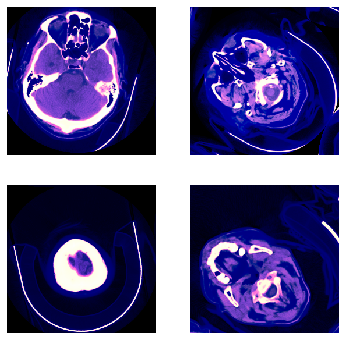

In [19]:
#x,y = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4)
#x.shape

In [20]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=6)

Loaded pretrained weights for efficientnet-b4


In [23]:
learn = Learner(dbch,model,#metrics=metrics,
                loss_func=loss_func,
                opt_func=opt_func,
                #cb_funcs=[SaveModelCallback()]
                model_dir=path/'data/preprocessed/models/eff_net').to_fp16()

In [24]:
learn.load('effb4-v2-256_8');

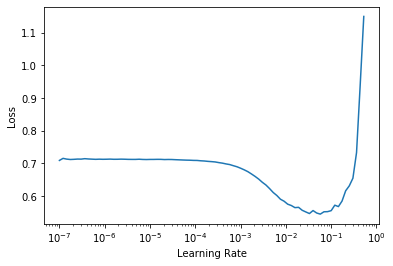

In [23]:
learn.lr_find()

In [23]:
lr = 1e-2/2

In [24]:
learn.fit_one_cycle(1,lr,cbs=[SaveModelCallback(every_epoch=True,fname='effb4-v2-224')])

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.073657,0.079359,0.972756,0.943710,2:46:58


KeyboardInterrupt: 

# Predict

In [42]:
test_fns = [(path_tst/f'{filename(o)}.dcm').absolute() for o in df_tst.fname.values]

In [26]:
tst = test_dl(dbch, test_fns)
x = tst.one_batch()[0]
x.min(),x.max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [27]:
preds,targs = learn.get_preds(dl=tst)
preds_clipped = preds.clamp(.0001, .999)

In [43]:
ids = []
labels = []

for idx,pred in zip(df_tst.index, preds_clipped):
    for i,label in enumerate(htypes):
        ids.append(f"{idx}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [44]:
sub_name = 'effb4_v2_074129'
df_test = pd.DataFrame({'ID': ids, 'Label': labels})
df_test.to_csv(f'{path}/data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [45]:
!~/.local/bin/kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f {path}/data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████| 3.53M/3.53M [00:01<00:00, 1.93MB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [46]:
df_test.head()

,ID,Label
0,ID_47a2de312_any,0.0029694452
1,ID_47a2de312_epidural,0.0001000000
2,ID_47a2de312_intraparenchymal,0.0002323142
3,ID_47a2de312_intraventricular,0.0001123533
4,ID_47a2de312_subarachnoid,0.0005658800


In [38]:
df_tst

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_47a2de312,CT,ID_ae549afd,ID_ed2df9f4f0,ID_823c0e49f8,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2779,14.395943,1202.477116,0.191402,NaN,NaN,NaN,NaN
1,ID_0ea75f68f,CT,ID_2e2abf40,ID_76ee69d498,ID_517894241c,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,3392,66.198795,1205.325972,0.279327,NaN,NaN,NaN,NaN
2,ID_508306a1f,CT,ID_ad5a9ac9,ID_dbfdc62c5a,ID_a698fcc176,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,1359,-362.891445,868.746300,0.003540,NaN,NaN,NaN,NaN
3,ID_efc19ad30,CT,ID_bc57b857,ID_7be6a5b9ee,ID_8691d27be3,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2334,-268.467430,1249.256516,0.242477,NaN,NaN,NaN,NaN
4,ID_ba886fcc2,CT,ID_e2441ca0,ID_eb2b4f4bef,ID_4c05f02584,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2742,-272.197708,985.178578,0.004242,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78540,ID_2ae0d88aa,CT,ID_a8ad5779,ID_d47acaa37c,ID_acd6099690,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2691,-63.696815,1127.306594,0.214935,NaN,NaN,NaN,NaN
78541,ID_9a9f16eb2,CT,ID_6cd2e3ef,ID_af3b1618d1,ID_5d8d8916c3,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,3111,-2.041527,1171.938815,0.133007,NaN,NaN,NaN,NaN
78542,ID_551c7b324,CT,ID_bc7cac97,ID_69011be73a,ID_5619b77de6,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,4095,42.623516,1160.855247,0.176113,NaN,NaN,NaN,NaN
78543,ID_1646c4307,CT,ID_206f10d8,ID_78f1246b45,ID_80e1ad5915,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2863,-58.554012,1114.333171,0.119411,NaN,NaN,NaN,NaN


In [39]:
df_tst = pd.read_feather(path_df/'df_tst.fth').set_index('SOPInstanceUID')